In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE

## Load geometric information

In [2]:
from scipy.io import loadmat

with h5py.File('Public/cytosolic_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


## Load the neural network


In [3]:
from vae_models.convnext_models import *

info = torch.load('../tb_logs/VAE_Evolver_sqh_beta=0_split=AP')
print('Model Loss: %.3g' % info['loss'])
v_model = VAE_Evolver(**info['hparams'])
v_model.load_state_dict(info['state_dict'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

v_model.to(device)
v_model.eval();

Model Loss: 0.0822


## Plotting script

In [18]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'


N0, N1 = 90, 110

def plot_with_cuts(ax, z, **kwargs):
    plot_tensor2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    cut_Y = np.sum(znorm[:118, N0:N1], axis=1) / np.sum(base[:118, N0:N1], axis=1)
    return cut_Y
    
def plot(m, v, t, dt=5, mmin=None, mmax=None, mask=None):
    dynamic_mask = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
    dynamic_time = np.load('Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
    msk = interp1d(dynamic_time, dynamic_mask, axis=0, fill_value='extrapolate')

    N = int(np.ceil(len(t) / dt))

    fig, ax = plt.subplots(2, N, figsize=(N+1, 1), dpi=300)
    fig.subplots_adjust(hspace=0, wspace=0.1)
    ax_cut = fig.add_axes([.92, 0.125, .75/N, 0.75])

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
        
    cut_sqh = []
    offset = 20
    for i in range(N):
        ax[0, i].set_title('t = %d' % (t[dt*i]))
        vi = v[dt*i].copy()
        vi[0] *= -1
        plot_vector2D(ax[0, i], vi, skip=20)
        ax[0, i].invert_yaxis()
        
        alpha = msk(t[dt*i]).astype(float)[mask]
        alpha[alpha == 0] = 1

        s1 = plot_with_cuts(ax[1, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0, alpha=alpha)    
        cut_sqh.append(s1)
        
        y = np.linspace(*ax[1, i].get_ylim(), len(s1))
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + offset)/ (np.max(t) + offset))
        ax_cut.plot(y, s1, color=sqh_color)
    
    for i in range(N):
        cut = cut_sqh[i]
        color = 'firebrick'
        y = np.linspace(*ax[1, i].get_ylim(), len(cut))

        ax_Y = ax[1, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[1, i])
        ax_Y.plot(cut, y, color=color, lw=0.5)
        ax_Y.fill_betweenx(y, np.ones_like(cut)*ax_cut.get_ylim()[0], cut,
                           color=color, alpha=0.7)

        ax_Y.set(xticks=[], yticks=[])
        ax_Y.set_xlim(ax_cut.get_ylim())
        ax_Y.invert_xaxis()
        ax_Y.axis('off')
            
    ax_cut.set(xticks=[], yticks=[], xlabel='DV')    

    lp=16
    ax[1, 0].set_ylabel('Myosin', labelpad=lp)
    ax[0, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 ax=ax_cut, label='Time (min)', ticks=[])

from utils.plot_utils import *

def comparison_plot(m, m0,
                    c, c0,
                    v, v0,
                    t, dt=5,
                    mask=np.s_[..., 20:-20, 0:-25]):
    N = int(np.ceil(len(t) / dt))
    fig, ax = plt.subplots(3, N+1, figsize=(N+1, 3.5), dpi=300, constrained_layout=True)

    mnorm = np.linalg.norm(m0[mask], axis=(1, 2))[..., :-20]
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    cmin = np.min(c0[mask])
    cmax = np.max(c0[mask])
        
    cut_cad = []
    cut_sqh = []
    
    alpha = np.zeros(m.shape[-2:])
    alpha0 = np.zeros_like(alpha)
    
    al = 0.7
    alpha[118:] = 1
    alpha0[:118] = al
    
    mwargs = dict(cmap='inferno', vmin=mmin, vmax=mmax)
    cwargs = dict(cmap='viridis', vmin=cmin, vmax=cmax)
    
    vfc = 40
    apc = 10
    skip = 20
    ylim = [dv_min+vfc, dv_max-vfc]
    xlim = [ap_min, ap_max]
    
    slc = np.s_[..., ::skip, ::skip]
    X = np.linspace(ap_min, ap_max, m.shape[-1])
    Y = np.linspace(dv_min, dv_max, m.shape[-2])
    Y, X = np.meshgrid(Y, X, indexing='ij')
    
    top = np.s_[..., 118:, :]
    bot = np.s_[..., :118, :]
    vwargs = dict(pivot='middle', width=0.005)

    axms = []
    axcs = []
    
    for i in range(N):
        ii = dt * i
        ax[0, i].set_title('t = %d' % (t[ii]))
    
        mwargs['both'] = t[ii] < 0
        color=plt.get_cmap('Reds')((t[ii] + 20)/ (np.max(t) + 20))
        plot_tensor2D(ax[0, i], m[ii], alpha=alpha, **mwargs)
        plot_tensor2D(ax[0, i], m0[ii], alpha=alpha0, **mwargs)
        
        def get_cut(z):
            znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
            base = np.ones_like(znorm)
            base[np.isnan(znorm)] = 0
            znorm = np.nan_to_num(znorm)
            cut = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
            return cut
        
        
        y = np.linspace(dv_min, dv_midpoint, 118)
        cut = get_cut(m[ii])
        cut0 = get_cut(m0[ii])
        ax[0, -1].plot(y, cut[:118], color=color)
        ax[0, -1].plot(y, cut0[:118], color=color, linestyle='--')
        
        cut = cut[118:]
        cut0 = cut0[:118]
        ax_Y = ax[0, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[0, i])
        ax_Y.plot(cut, y+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(y+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, y, color=color, lw=0.5, alpha=al)
        ax_Y.fill_betweenx(y, 0, cut0, color=color, alpha=0.7*al)
        axms.append(ax_Y)
        
        color=plt.get_cmap('Blues')((t[ii] + 20)/ (np.max(t) + 20))
        color_2D(ax[1, i], c[ii], alpha=alpha, **cwargs)
        color_2D(ax[1, i], c0[ii], alpha=alpha0, **cwargs)
    
        y = np.linspace(dv_min, dv_midpoint, 118)
        cut = get_cut(c[ii])
        cut0 = get_cut(c0[ii])
        ax[1, -1].plot(y, cut[:118], color=color)
        ax[1, -1].plot(y, cut0[:118], color=color, linestyle='--')
        
        cut = cut[118:]
        cut0 = cut0[:118]
        ax_Y = ax[1, i].inset_axes([-0.25, 0, 0.2, 1], sharey=ax[1, i])
        ax_Y.plot(cut, y+dv_midpoint, color=color, lw=0.5)
        ax_Y.fill_betweenx(y+dv_midpoint, 0, cut, color=color, alpha=0.7)
        ax_Y.plot(cut0, y, color=color, lw=0.5, alpha=al)
        ax_Y.fill_betweenx(y, 0, cut0, color=color, alpha=0.7*al)
        axcs.append(ax_Y)
        
        ax[2, i].quiver(X[bot][slc], Y[bot][slc], 
                        v0[ii, 1][bot][slc], v0[ii, 0][bot][slc],
                        color='grey', **vwargs)
        ax[2, i].quiver(X[top][slc], Y[top][slc], 
                        v[ii, 1][top][slc], v[ii, 0][top][slc],
                        color='black', **vwargs)
        ax[2, i].set(xticks=[], yticks=[])

        
        for j in range(3):
            ax[j, i].set(xlim=xlim, ylim=ylim)
            ax[j, i].set_aspect('equal')
            
    ax[0, -1].set_xlim([dv_min+vfc, dv_midpoint])
    ax[1, -1].set_xlim([dv_min+vfc, dv_midpoint])

    
    for i in range(N):
        axms[i].set(xlim=ax[0, -1].get_ylim())
        axms[i].invert_xaxis()
        axms[i].axis('off')
            
        axcs[i].set(xlim=ax[1, -1].get_ylim())
        axcs[i].invert_xaxis()
        axcs[i].axis('off')
            
    ax[0, -1].set(xticks=[], yticks=[], xlabel='DV')    
    ax[1, -1].set(xticks=[], yticks=[], xlabel='DV')
    ax[0, -1].autoscale(axis='y')
    ax[1, -1].autoscale(axis='y')

    
    lp=16
    ax[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig.subplots_adjust(right=0.98, wspace=0.4, hspace=0.3)


    cax = fig.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])
    
    res_m = mean_norm_residual(m0[mask], m[mask]).mean(axis=(1, 2))
    res_c = residual(c0[mask], c[mask]).mean(axis=(1, 2))
    res_v = residual(v0[mask], v[mask]).mean(axis=(1, 2))
    vnorm = np.linalg.norm(v, axis=1).mean(axis=(1, 2))
    ax[2, N].plot(t, res_m, color='firebrick')
    ax[2, N].plot(t, res_c, color='steelblue')
    
    
    
    ax2 = ax[2, N].twinx()
    ax2.plot(t, vnorm, color='black')
    
    ax[2, N].set_ylabel('Error Rate', labelpad=-6)
    ax2.set_ylabel('Mean flow\n($\mu$m / min)')
    ax[2, N].set_yticks([0, 1])
    ax[2, N].set_ylim([0, 1])
    
#plot(m, v, t, dt=10, mmin=mmin, mmax=mmax, mask=mask)

## Integrate!

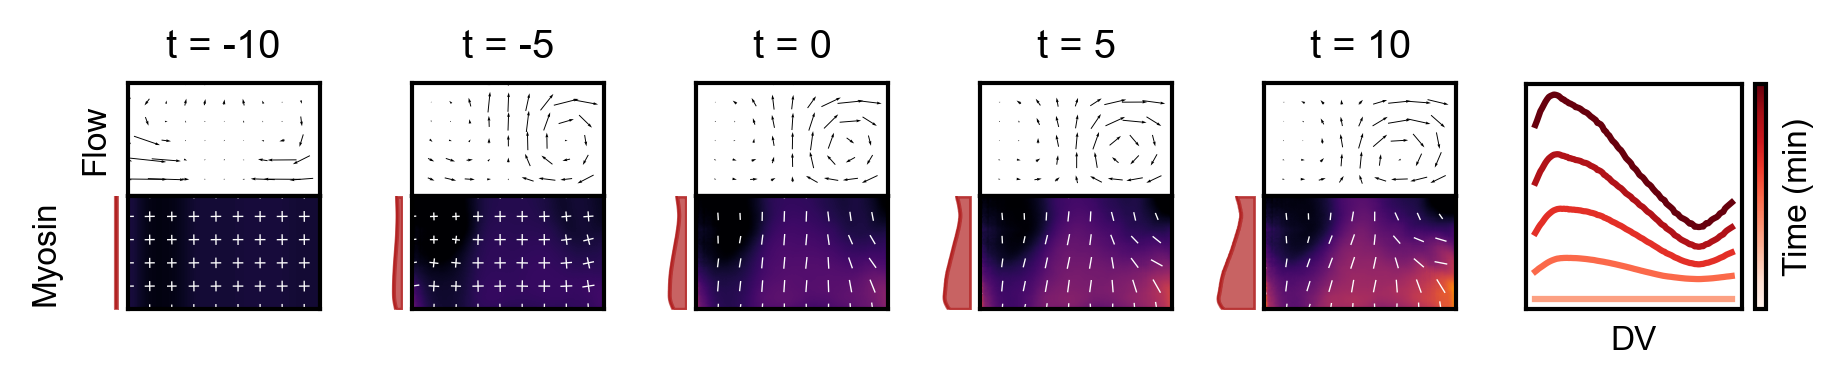

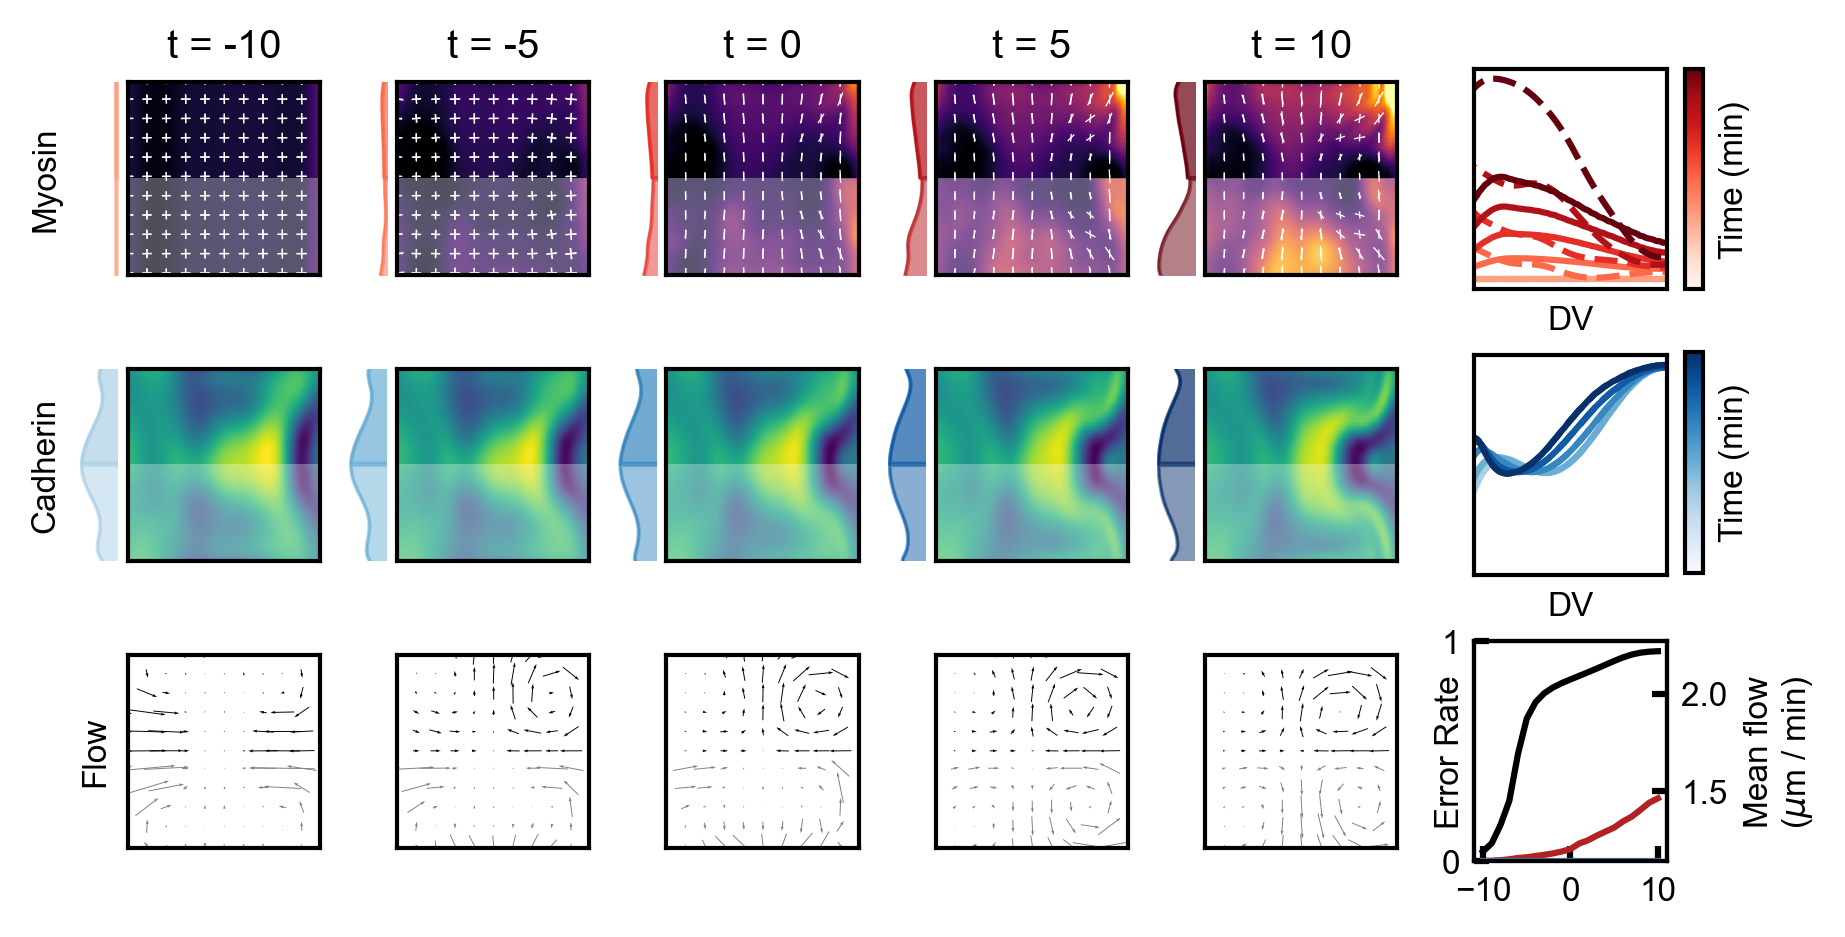

In [19]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition_utils import LeftRightSymmetrize
from utils.plot_utils import *

from torchdiffeq import odeint as odeint

def gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    if order == 0:
        return phi_x
    else:
        # f(x) = q(x) * phi(x) = q(x) * exp(p(x))
        # f'(x) = (q'(x) + q(x) * p'(x)) * phi(x)
        # p'(x) = -1 / sigma ** 2
        # Implement q'(x) + q(x) * p'(x) as a matrix operator and apply to the
        # coefficients of q(x)
        q = np.zeros(order + 1)
        q[0] = 1
        D = np.diag(exponent_range[1:], 1)  # D @ q(x) = q'(x)
        P = np.diag(np.ones(order)/-sigma2, -1)  # P @ q(x) = q(x) * p'(x)
        Q_deriv = D + P
        for _ in range(order):
            q = Q_deriv.dot(q)
        q = (x[:, None] ** exponent_range).dot(q)
        return q * phi_x


class ClosedFlyLoop(nn.Module):
    def __init__(self, YY, XX, v_model,
                 thresh=0.,
                 v_int=None,
                 sigma=3):
        super(ClosedFlyLoop, self).__init__()
        self.v_model = v_model.double()
        self.v_int = v_int
        
        self.thresh = thresh
        self.gamma_dv = nn.Parameter(
            torch.DoubleTensor([
                [1., 0.], 
                [0., 0.]
            ])[..., None, None], requires_grad=False)
        
        self.nDV = YY.shape[0]
        self.nAP = XX.shape[0]

        self.dAP = XX[1] - XX[0]
        self.dDV = YY[1] - YY[0]
        if not isinstance(sigma, tuple):
            sigma = (sigma, sigma)
        dv_kernel = gaussian_kernel1d(
            sigma=sigma[0],
            order=1,
            radius=int(4*sigma[0]+0.5))
        ap_kernel = gaussian_kernel1d(
            sigma=sigma[1],
            order=1,
            radius=int(4*sigma[1]+0.5))
        
        #Reverse order as in scipy.ndimage.gaussian_filter1d
        dv_kernel = dv_kernel[::-1].copy()
        ap_kernel = ap_kernel[::-1].copy()
        
        self.dv_kernel = nn.Parameter(torch.from_numpy(dv_kernel[None, None]), requires_grad=False)
        self.ap_kernel = nn.Parameter(torch.from_numpy(ap_kernel[None, None]), requires_grad=False)
        
        self.dv_pad = self.dv_kernel.shape[-1] // 2
        self.ap_pad = self.ap_kernel.shape[-1] // 2
        
        Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        self.Gijk = nn.Parameter(torch.DoubleTensor(Gijk), requires_grad=False)
        
    def embryo_pad(self, x):
        '''
        x0 is a [..., H, W] field 
        We will pad it periodic in the DV direction (H) 
            and constant in the AP direction (W)
        '''
        c = x.shape[0:-2]
        h, w = x.shape[-2:]
        x = x.reshape([-1, h, w])
        
        #AP Pad - replicate
        ap = 2*self.ap_pad
        x = F.pad(x, (ap, ap), mode='replicate')
        
        #DV pad - periodic
        dv = 2*self.dv_pad
        x = x.permute(0, 2, 1)
        x = F.pad(x, (dv, dv), mode='circular')
        x = x.permute(0, 2, 1)
        
        x = x.reshape([*c, h+2*dv, w+2*ap])
        
        return x
    
    def gradient(self, x0):
        c = x0.shape[0:-2]
        h, w = x0.shape[-2:]
        
        x = x0.reshape([-1, h, w])
        x = self.embryo_pad(x)
        
        dv, ap = self.dv_pad, self.ap_pad
        hp, wp = x.shape[-2:]

        dY = x.permute(0, 2, 1).reshape([-1, 1, h+4*dv])
        dY = F.conv1d(dY, self.dv_kernel) / self.dDV
        dY = dY.reshape([-1, w+4*ap, h+2*dv]).permute(0, 2, 1)
        dY = dY[:, dv:-dv, 2*ap:-2*ap].reshape([*c, h, w])
        
        dX = x.reshape([-1, 1, w+4*ap])
        dX = F.conv1d(dX, self.ap_kernel) / self.dAP
        dX = dX.reshape([-1, h+4*dv, w+2*ap])
        dX = dX[:, 2*dv:-2*dv, ap:-ap].reshape([*c, h, w])
        
        return torch.stack([dY, dX], dim=-1)
    
    def covariant_gradient(self, x0):
        grad_x = self.gradient(x0)
        if len(x0.shape) == 3: #Vector
            grad_x += torch.einsum('yxijk,kyx->iyxj', self.Gijk, x0)
        elif len(x0.shape) == 4: #Tensor
            grad_x += torch.einsum('yxikl,ljyx->ijyxk', self.Gijk, x0) + \
                      torch.einsum('yxjkl,ilyx->ijyxk', self.Gijk, x0)
        return grad_x
    
    def get_velocity(self, t, y):
        if self.v_int is None: 
            v, _ = VAE.forward(self.v_model, y.reshape([-1, *y.shape[-3:]]))
        
        else:
            t0 = t.cpu().numpy()
            v = self.v_int(t0)
            v = torch.from_numpy(v).to(y.device)
            
        #Left-right symmetrize
        v_lr = torch.flip(v, (-2,))
        v_lr[..., 0, :, :] *= -1
        v = 0.5 * (v + v_lr)
        
        #Threshold
        vnorm = torch.linalg.norm(v, dim=-3, keepdims=True)
        mask = vnorm >= self.thresh
        v *= mask
        
        return v
        
    def forward(self, t, y):
        #Get myosin and source
        m = y[:4].reshape([2, 2, self.nDV, self.nAP])
        s = y[4:].squeeze()
        
        #Compute flow from myosin/cadherin
        v = self.get_velocity(t, y[:4]).squeeze()
        
        #Sources
        dv = self.gamma_dv[:, :, None, None]

        #Gradients
        d1_m = self.covariant_gradient(m)
        d1_s = self.covariant_gradient(s)
        d1_v = self.covariant_gradient(v)

        #Flow derivative tensors
        O = -0.5 * (torch.einsum('iyxj->ijyx', d1_v) - \
                    torch.einsum('jyxi->ijyx', d1_v))
        E = 0.5 * (torch.einsum('iyxj->ijyx', d1_v) + \
                   torch.einsum('jyxi->ijyx', d1_v))

        #Active/Passive strain decomposition
        deviatoric = m - 0.5 * torch.einsum('kkyx,ij->ijyx', 
                                            m, torch.eye(2, device=m.device))

        m_0 = torch.linalg.norm(m, dim=(0, 1), keepdims=True).mean(dim=(2, 3), keepdims=True)
        dev_mag = torch.linalg.norm(deviatoric, axis=(0, 1), keepdims=True)

        devE = torch.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

        E_active = E - torch.sign(devE) * devE * deviatoric / dev_mag**2
        E_active = 0.5 * E_active * dev_mag / m_0 
        E_passive = E - E_active

        mE = torch.einsum('ikyx,kjyx->ijyx', m, E_passive) + \
             torch.einsum('ikyx,kjyx->ijyx', E_passive, m) 

        trm = torch.einsum('kkyx->yx', m)[None, None]

        
        #Source is passively advected
        sdot = -1.000 * torch.einsum('iyx,yxi->yx', v, d1_s)
        
        s = s[None, None]
        #Myosin dynamics
        mdot =  -1.000 * torch.einsum('kyx,ijyxk->ijyx', v, d1_m)
        mdot -= +1.000 * torch.einsum('ikyx,kjyx->ijyx', O, m)
        mdot -= -1.000 * torch.einsum('ikyx,kjyx->ijyx', m, O)
        #D_t m_ij  = 1.431 m_ij Tr(E_passive)
        #D_t m_ij = 0.305 * Tr(m) * m_ij - 0.160 * {m, E}
        #D_t m_ij  = 0.007 Static_DV Tr(m_ij) + 1.368 m_ij Tr(E_passive) + 0.188 m_ij Tr(m_ij)
        #D_t m_ij  = -0.010 m_ij + 1.351 m_ij Tr(E_passive) + 0.012 Static_DV Tr(m_ij) + 0.221 m_ij Tr(m_ij)
        #D_t m_ij  = 0.024 Static_DV Tr(m_ij) + -0.023 m_ij + 1.335 m_ij Tr(E_passive) + 0.152 m_ij Tr(m_ij)
        #D_t m_ij  = 0.095 Static_DV Tr(m_ij) + -0.001 m_ij + 1.402 m_ij Tr(E_passive) + 0.220 m_ij Tr(m_ij) + 0.008 {m_ij, E_passive} + -0.054 {m_ij, Static_DV}
        #D_t m_ij  = -0.001 E_passive + 0.034 E_passive Tr(m_ij) + 0.122 Static_DV Tr(m_ij) + 0.030 m_ij + 1.357 m_ij Tr(E_passive) + -0.075 m_ij Tr(m_ij) + 0.332 m_ij m_ij + -0.021 {m_ij, E_passive} + -0.083 {m_ij, Static_DV}
        #D_t m_ij  = -0.016 m_ij + 1.319 m_ij Tr(E_passive) + 0.022 Static_DV Tr(m_ij) + 
        #            0.129 m_ij Tr(m_ij) + 0.026 Dorsal_Source m_ij + -0.290 Dorsal_Source m_ij Tr(E_passive) + 
        #            -0.003 Dorsal_Source Static_DV + 0.007 Dorsal_Source m_ij Tr(m_ij)        
        
        #mdot += -0.010 * m
        #mdot += 1.351 * m * torch.einsum('kkyx->yx', E_passive)
        #mdot += 0.012 * trm * self.gamma_dv
        #mdot += 0.221 * trm * m
        
        #mdot += -1 * (0.016 - 0.026 * s) * m
        #mdot += (1.319 - 0.290 * s) * m * torch.einsum('kkyx->yx', E_passive)
        #mdot += (0.026 - 0.003 * s) * trm * self.gamma_dv
        #mdot += (0.129 + 0.007 * s) * trm * m

        #mdot += -1 * (0.008 - 0.075 * s) * m
        #mdot += (1.378 - 1.212 * s) * m * torch.einsum('kkyx->yx', E_passive)
        #mdot += (0.013 - 0.004 * s) * trm * self.gamma_dv
        #mdot += (0.194 - 0.525 * s) * trm * m
        
        #D_t m = -(0.514 - 0.549 s) m + (1.34 - 1 s){m, E_p} + (1.74 - 1.77 s) Tr(m) Gamma^{DV} + (1.66 - 1.68 s) Tr(m) m
        mdot += -(0.514 - 0.549 * s) * m
        mdot +=  (1.340 - 1.000 * s) * m * torch.einsum('kkyx->yx', E_passive)
        mdot +=  (1.74 - 1.77 * s) * trm * self.gamma_dv
        mdot +=  (1.66 - 1.68 * s) * trm * m
        
        ydot = torch.cat([
            mdot.reshape([4, self.nDV, self.nAP]),
            sdot.reshape([1, self.nDV, self.nAP]),
        ])

        return ydot
    
def integrate(m0, s0, v_model, times, YY, XX, v0=None, thresh=0.):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field determined by ML
    and two source fields
    ''' 
        
    #Set up interpolators for control fields
    if v0 is None:
        v_int = None
    else:
        v_int = interp1d(times, v0, axis=0, fill_value='extrapolate')
    
    model = ClosedFlyLoop(YY, XX, v_model, 
                          v_int=v_int,
                          thresh=thresh,
                          sigma=(7, 5))
    model.to(device)

    y0 = np.concatenate([
        m0.reshape([4, *m0.shape[-2:]]),
        s0.reshape([1, *s0.shape[-2:]]),
    ])    
    y0 = torch.from_numpy(y0).to(device)
    t = torch.DoubleTensor(times).to(device)
    
    with torch.no_grad():
        y = odeint(model, y0, t, method='rk4')
        m = y[:, :4].reshape([-1, 2, 2, *y.shape[-2:]]).cpu().numpy()
        s = y[:, 4:].cpu().numpy()
        model.v_int = None
        v = model.get_velocity(t, y[:, :4]).cpu().numpy()
            
    return model, (m, s, v, times)

'''
Collect initial conditions - m, c, v, gamma_d, gamma_dv, and time
'''
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    tmin = -10
    sigma = 5
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['X_raw/Dorsal_Source'][t_mask, ...][()]
    
    s0 = np.load('ClosedLoopPINN/DorsalSource_IC.npy')[None]
    
    s0 = gaussian_filter(s0, sigma=(0, sigma, sigma))
    v0 = data['fields/v'][t_mask, ...][()]
    v0 = LeftRightSymmetrize().fit_transform(v0)
    t0 = t[t_mask, ...][()]
    
    #If we're using synthetic ICs, remove DV grading
    m0_mean = np.mean(m0[0], axis=-2, keepdims=True)
    m0[0] = np.broadcast_to(m0_mean, m0[0].shape)

model, (m, s, v, t) = integrate(
    m0[0], s0[0], v_model,
    t0, dv, ap, thresh=0.)
s0 = s

mnorm = np.linalg.norm(m0, axis=(1, 2))
mmin = np.min(mnorm)
mmax = np.max(mnorm)
mask = np.s_[..., 20:-20, 0:-25]

plot(m, v, t, dt=5, mmin=mmin, mmax=mmax, mask=mask)
comparison_plot(m, m0,
                s, s0,
                v, v0,
                t, dt=5)